***
##### Import the necessary libraries

In [1]:
import re
import json
import string
import datetime
import random
import itertools
from collections import OrderedDict, defaultdict

import random
import datetime
from gensim import corpora
import pandas as pd
import numpy as np
import FastLDA
from pSSLDA import infer
from os import path
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_rows', 50)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 7)

warnings.filterwarnings("ignore")

***
##### Load the depression lexicon file and tweets data

In [2]:
with open("depression_lexicon.json") as f:
    seed_terms = json.load(f)

In [3]:
tweets_df = pd.read_csv('Data/tweets_cleaned.csv')
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

In [4]:
tweets_df_50 = tweets_df[tweets_df._50 == 1]
tweets_df_70 = tweets_df[tweets_df._70 == 1]
tweets_df_100 = tweets_df[tweets_df._100 == 1]

In [5]:
users = set(tweets_df['username'].to_list())
users_50 = set(tweets_df_50['username'].to_list())
users_70 = set(tweets_df_70['username'].to_list())
users_100 = set(tweets_df_100['username'].to_list())

In [6]:
tweets_df = tweets_df[["tweet_id", "created_at", "text",
                       "cleaned_text", "vader_compound_raw", 'username']]
tweets_df.columns = ["tweet_ID", "created_at",
                     "raw_text", "cleaned_text", "sentiment", 'username']
tweets_df_50 = tweets_df_50[["tweet_id", "created_at",
                             "text", "cleaned_text", "vader_compound_raw", 'username']]
tweets_df_50.columns = ["tweet_ID", "created_at",
                        "raw_text", "cleaned_text", "sentiment", 'username']
tweets_df_70 = tweets_df_70[["tweet_id", "created_at",
                             "text", "cleaned_text", "vader_compound_raw", 'username']]
tweets_df_70.columns = ["tweet_ID", "created_at",
                        "raw_text", "cleaned_text", "sentiment", 'username']
tweets_df_100 = tweets_df_100[["tweet_id", "created_at",
                               "text", "cleaned_text", "vader_compound_raw", 'username']]
tweets_df_100.columns = ["tweet_ID", "created_at",
                         "raw_text", "cleaned_text", "sentiment", 'username']

In [7]:
# Filter for users who have at least 100 tweets in past 3 months
if path.exists("Data/user_sample.txt"):
    file = open("Data/user_sample.txt", "r")
    lines = file.read()
    user_sample = lines.split("\n")
else:
    user_sample = random.sample(users_100, 10)
    with open("Data/user_sample.txt", "w") as file:
        lines = "\n".join(user_sample)
        file.write(lines)

***
##### To emulate PHQ-9 questionare, we bucket tweets based on their creation time with a sliding window of 14 days for each user. Each of these buckets will be treated as a document.

In [8]:
def create_time_buckets(tweets):

    bucketed_tweets = defaultdict(list)

    days = 14
    counter = 0

    start_date = tweets.created_at.dt.date.min()
    end_date = tweets.created_at.dt.date.max() + timedelta(days=1)

    new_start = start_date
    new_end = start_date + timedelta(days=14)

    while True:

        if new_end <= end_date:

            mask = (tweets['created_at'] >= new_start) & (
                tweets['created_at'] <= new_end)
            df = tweets[mask]

            for index, tweet in df.iterrows():
                bucketed_tweets[counter].append(tweet)

            new_start = new_start + timedelta(days=1)
            new_end = new_end + timedelta(days=1)

            counter += 1

        else:
            break

    return bucketed_tweets

In [10]:
user_bucketed_tweets = {}

for user in user_sample:
    user_bucketed_tweets[user] = create_time_buckets(
        tweets_df[tweets_df['username'] == user])

***
##### Prepare the data for LDA from the bucketed tweets

In [13]:
def data_prep(bucketed_tweets):

    texts = list()
    text_as_ids = list()
    doc_as_ids = list()

    number_of_docs = len(bucketed_tweets)

    for bucket in bucketed_tweets:
        all_bucket_tweets = ""
        for tweet in bucketed_tweets[bucket]:
            all_bucket_tweets += str(tweet.cleaned_text) + " "
        texts.append(all_bucket_tweets.strip().replace("\n", "").split(" "))

    dictionary = corpora.Dictionary(texts)
    dictionary.compactify()
    voc_size = len(list(dictionary.keys()))

    # replace token ids with the token text in each doc and return similar arry of tokens and docs to later be the docvec
    for x in range(number_of_docs):
        doc = texts[x]
        for token in doc:
            text_as_ids.append(dictionary.token2id[token])
            doc_as_ids.append(x)

    return text_as_ids, doc_as_ids, voc_size, dictionary.token2id, number_of_docs, bucketed_tweets

In [14]:
user_LDA_inputs = {}

for user in user_sample:
    user_LDA_inputs[user] = data_prep(user_bucketed_tweets[user])

***
##### Helper functions

In [18]:
def get_avg_sentiment(bucketed_tweets, token):

    score = 0.0
    count = 0

    term_tweets_sent_scores = get_tweets_by_term(bucketed_tweets, token)

    for sent_score in term_tweets_sent_scores:
        score += float(sent_score)
        count += 1

    return score / count


def get_tweets_by_term(bucketed_tweets, term):

    term_tweets_sent_scores = list()

    for bucket in bucketed_tweets:
        for tweet in bucketed_tweets[bucket]:
            if term in str(tweet.cleaned_text):
                term_tweets_sent_scores.append(tweet.sentiment)

    return term_tweets_sent_scores


def get_topics_terms(tup):

    topics_dict = defaultdict(defaultdict)

    estphi = tup[0]
    W = tup[1]
    T = tup[2]
    id2token = tup[3]

    for index in range(W):
        term_weights = estphi[:, index]
        largest_weight = 0

        for weight in term_weights:
            if weight > largest_weight:
                largest_weight = weight

        term_topic = np.argwhere(term_weights == largest_weight)[0][0]
        topics_dict[term_topic][id2token[index]] = largest_weight

    return topics_dict


def get_all_terms_sentiments(id2token, w, bucketed_tweets):

    seed_term_sentiment = defaultdict(float)

    w = list(set(w))

    for wi in w:

        token = id2token[wi]

        if token in seed_terms['signal_1']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_2']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_3']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_4']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_5']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_6']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_7']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_8']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_9']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

        elif token in seed_terms['signal_10']:
            seed_term_sentiment[token] = get_avg_sentiment(
                bucketed_tweets, token)

    return seed_term_sentiment

***
##### Run LDA 

In [19]:
def run_LDA(LDA_input, parameters):
    
    token2id = LDA_input[3]

    # number of topics
    T = parameters["topics_count"]

    (wordvec, docvec, zvec) = ([], [], [])

    # vector of words per tweet
    wordvec = LDA_input[0]
    docvec = LDA_input[1]

    # W = vocabulary size
    W = LDA_input[2]

    (w, d) = (np.array(wordvec, dtype = np.int), np.array(docvec, dtype = np.int))

    # Create parameters
    alpha = np.ones((1,T)) * 1
    beta = np.ones((T,W)) * 0.01

    # How many parallel samplers do we wish to use?
    P = 1

    # Random number seed
    randseed =  random.randint(999,999999)

    # Number of samples to take
    numsamp = 500

    # Do parallel inference
    final_z = infer(w, d, alpha, beta, numsamp, randseed, P)

    # number of documents = tweets
    D = LDA_input[4]

    # Estimate phi and theta
    (nw, nd) = FastLDA.countMatrices(w, W, d, D, final_z, T)
    (estphi,esttheta) = FastLDA.estPhiTheta(nw, nd, alpha, beta)

    # swap keys with values in the token2id => id2token
    id2token = dict((v,k) for k,v in token2id.iteritems())

    seed_term_sentiment = get_all_terms_sentiments(id2token, w, LDA_input[5])

    # Now, we add z-labels to *force* words into separate topics
    
    labelweight = 5.0

    label0 = np.zeros((T,), dtype=np.float)
    label0[0] = labelweight

    label1 = np.zeros((T,), dtype=np.float)
    label1[1] = labelweight

    label2 = np.zeros((T,), dtype=np.float)
    label2[2] = labelweight

    label3 = np.zeros((T,), dtype=np.float)
    label3[3] = labelweight

    label4 = np.zeros((T,), dtype=np.float)
    label4[4] = labelweight

    label5 = np.zeros((T,), dtype=np.float)
    label5[5] = labelweight

    label6 = np.zeros((T,), dtype=np.float)
    label6[6] = labelweight

    label7 = np.zeros((T,), dtype=np.float)
    label7[7] = labelweight

    label8 = np.zeros((T,), dtype=np.float)
    label8[8] = labelweight

    label9 = np.zeros((T,), dtype=np.float)
    label9[9] = labelweight

    label10 = np.zeros((T,), dtype=np.float)
    label10[10] = labelweight

    label11 = np.zeros((T,), dtype=np.float)
    label11[11] = labelweight

    # signals ids
    corpus_signals = [0,1,2,3,4,5,6,7,8,9]
   
    seed_terms_per_signal = defaultdict(lambda: defaultdict(int))

    z_labels = []
    for wi in w:

        token = id2token[wi]

        # if the word appears in topic 0
        if token in seed_terms['signal_1'] and  seed_term_sentiment[token] <= 0:

            z_labels.append(label0)

            seed_terms_per_signal['signal_1'][token]+=1

            if 0 in corpus_signals:
                corpus_signals.remove(0)


        elif token in seed_terms['signal_2'] and  seed_term_sentiment[token] <= 0:

            z_labels.append(label1)

            seed_terms_per_signal['signal_2'][token]+=1

            if 1 in corpus_signals:
                corpus_signals.remove(1)


        elif token in seed_terms['signal_3'] and seed_term_sentiment[token] <= 0:

            z_labels.append(label2)

            seed_terms_per_signal['signal_3'][token]+=1

            if 2 in corpus_signals:
                corpus_signals.remove(2)


        elif token in seed_terms['signal_4'] and seed_term_sentiment[token] <= 0:

            z_labels.append(label3)
            seed_terms_per_signal['signal_4'][token]+=1

            if 3 in corpus_signals:
                corpus_signals.remove(3)


        elif token in seed_terms['signal_5'] and seed_term_sentiment[token] <= 0:

            z_labels.append(label4)

            seed_terms_per_signal['signal_5'][token]+=1

            if 4 in corpus_signals:
                corpus_signals.remove(4)

        elif token in seed_terms['signal_6'] and  seed_term_sentiment[token] <= 0:

            z_labels.append(label5)

            seed_terms_per_signal['signal_6'][token]+=1

            if 5 in corpus_signals:
                corpus_signals.remove(5)

        elif token in seed_terms['signal_7'] and  seed_term_sentiment[token] <= 0:

            z_labels.append(label6)

            seed_terms_per_signal['signal_7'][token]+=1

            if 6 in corpus_signals:
                corpus_signals.remove(6)

        elif token in seed_terms['signal_8'] and  seed_term_sentiment[token] <= 0:

            z_labels.append(label7)

            seed_terms_per_signal['signal_8'][token]+=1

            if 7 in corpus_signals:
                corpus_signals.remove(7)

        elif token in seed_terms['signal_9'] and  seed_term_sentiment[token] <= 0:

            z_labels.append(label8)

            seed_terms_per_signal['signal_9'][token]+=1

            if 8 in corpus_signals:
                corpus_signals.remove(8)

        elif token in seed_terms['signal_10'] and  seed_term_sentiment[token] <= 0:

            z_labels.append(label9)

            seed_terms_per_signal['signal_10'][token]+=1

            if 9 in corpus_signals:
                corpus_signals.remove(9)

        else:
            z_labels.append(None)

    # Now inference will find topics with 0 and 1 in separate topics
    final_z = infer(w, d, alpha, beta, numsamp, randseed, P, zlabels = z_labels)

    # Re-estimate phi and theta
    (nw, nd) = FastLDA.countMatrices(w, W, d, D, final_z, T)
    (estphi,esttheta) = FastLDA.estPhiTheta(nw, nd, alpha, beta)

    # Find the sentiment of each topic cluster based on the tweets where each seed term appered in

    tup = (estphi, W, T, id2token)
    topics_terms = get_topics_terms(tup)
    
    sent_scores = defaultdict(list)

    counter = 0
    for topic in topics_terms:

        topic_sent_scores = list()

        for term in topics_terms[topic]:
            term_tweets_sent_scores = get_tweets_by_term(LDA_input[5], term)

            for sent_score in term_tweets_sent_scores:
                 topic_sent_scores.append(float(sent_score))

        avg = sum(topic_sent_scores) / float(len(topic_sent_scores))

        sent_scores[topic] = (topic_sent_scores, avg)
        
        counter+=1

    # post processing of topics. If the bucket has less than 30 tweets then discard the probabilities of that bucket

    len_buckets = []
    for bucket in LDA_input[5]:
        len_b = len(LDA_input[5][bucket])
        len_buckets.append(len_b)

   
    # threshold #1: if number of tweets in that bucket is less than x, then discard that bucket.
    min_number_of_tweets_per_bucket = parameters["min_tweets_per_bucket"]
    
    for x in range(len(len_buckets)):
        if len_buckets[x] <= min_number_of_tweets_per_bucket:
            esttheta[x, :] = 0

    # this will replace zero to the probabilities of the topic by ID if no seed terms were found in the corpus
    for topic_id in corpus_signals:
        esttheta[:, topic_id] = 0

    all_topics_seeds = list()
    for signal in seed_terms_per_signal:
        all_topics_seeds += seed_terms_per_signal[signal]

    # topics to keep
    seeds_in_top_k = defaultdict(int)

    # number of seed terms that should be in the top topic terms
    seeds_threshold = parameters["seeds_threshold"]
    
    # The number of terms in the topic that we will look into to search for seed terms
    top_topic_terms = parameters["top_topic_terms"]

    for topic in topics_terms:
        for x in range(len(topics_terms[topic])):
            term = list(topics_terms[topic])[x]
            if x < top_topic_terms:
                if term in all_topics_seeds:
                    seeds_in_top_k[topic] += 1

    # this will replace zero to the probabilities of the topic by ID if no seed terms were found in the corpus
    for x in range(len(esttheta[0])):
        if x in seeds_in_top_k.keys():
            if seeds_in_top_k[x] < seeds_threshold:
                esttheta[:, x] = 0
        else:
            esttheta[:, x] = 0


    return (estphi, W, T, id2token), esttheta, topics_terms, seed_terms_per_signal

In [20]:
parameters = {"topics_count": 15, "min_tweets_per_bucket": 10, "seeds_threshold": 2, "top_topic_terms": 25}

user_LDA_outputs={}
for user in user_sample:
    user_LDA_outputs[user] = run_LDA(user_LDA_inputs[user], parameters)

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launchi

Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Gettin

Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453

Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444

Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465

Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477

Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455

Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408

Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390 of 500
Sample 391 of 500
Sample 392 of 500
Sample 393 of 500
Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402

Sample 335 of 500
Sample 336 of 500
Sample 337 of 500
Sample 338 of 500
Sample 339 of 500
Sample 340 of 500
Sample 341 of 500
Sample 342 of 500
Sample 343 of 500
Sample 344 of 500
Sample 345 of 500
Sample 346 of 500
Sample 347 of 500
Sample 348 of 500
Sample 349 of 500
Sample 350 of 500
Sample 351 of 500
Sample 352 of 500
Sample 353 of 500
Sample 354 of 500
Sample 355 of 500
Sample 356 of 500
Sample 357 of 500
Sample 358 of 500
Sample 359 of 500
Sample 360 of 500
Sample 361 of 500
Sample 362 of 500
Sample 363 of 500
Sample 364 of 500
Sample 365 of 500
Sample 366 of 500
Sample 367 of 500
Sample 368 of 500
Sample 369 of 500
Sample 370 of 500
Sample 371 of 500
Sample 372 of 500
Sample 373 of 500
Sample 374 of 500
Sample 375 of 500
Sample 376 of 500
Sample 377 of 500
Sample 378 of 500
Sample 379 of 500
Sample 380 of 500
Sample 381 of 500
Sample 382 of 500
Sample 383 of 500
Sample 384 of 500
Sample 385 of 500
Sample 386 of 500
Sample 387 of 500
Sample 388 of 500
Sample 389 of 500
Sample 390

Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451

Sample 394 of 500
Sample 395 of 500
Sample 396 of 500
Sample 397 of 500
Sample 398 of 500
Sample 399 of 500
Sample 400 of 500
Sample 401 of 500
Sample 402 of 500
Sample 403 of 500
Sample 404 of 500
Sample 405 of 500
Sample 406 of 500
Sample 407 of 500
Sample 408 of 500
Sample 409 of 500
Sample 410 of 500
Sample 411 of 500
Sample 412 of 500
Sample 413 of 500
Sample 414 of 500
Sample 415 of 500
Sample 416 of 500
Sample 417 of 500
Sample 418 of 500
Sample 419 of 500
Sample 420 of 500
Sample 421 of 500
Sample 422 of 500
Sample 423 of 500
Sample 424 of 500
Sample 425 of 500
Sample 426 of 500
Sample 427 of 500
Sample 428 of 500
Sample 429 of 500
Sample 430 of 500
Sample 431 of 500
Sample 432 of 500
Sample 433 of 500
Sample 434 of 500
Sample 435 of 500
Sample 436 of 500
Sample 437 of 500
Sample 438 of 500
Sample 439 of 500
Sample 440 of 500
Sample 441 of 500
Sample 442 of 500
Sample 443 of 500
Sample 444 of 500
Sample 445 of 500
Sample 446 of 500
Sample 447 of 500
Sample 448 of 500
Sample 449

Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sampl

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sampl

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
S

Sample 448 of 500
Sample 449 of 500
Sample 450 of 500
Sample 451 of 500
Sample 452 of 500
Sample 453 of 500
Sample 454 of 500
Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Online z initialization
Assigning documents to partitions
Gettin

Sample 455 of 500
Sample 456 of 500
Sample 457 of 500
Sample 458 of 500
Sample 459 of 500
Sample 460 of 500
Sample 461 of 500
Sample 462 of 500
Sample 463 of 500
Sample 464 of 500
Sample 465 of 500
Sample 466 of 500
Sample 467 of 500
Sample 468 of 500
Sample 469 of 500
Sample 470 of 500
Sample 471 of 500
Sample 472 of 500
Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500


In [21]:
def detect_depression(LDA_output, user):
    
    try:

        esttheta = LDA_output[1]
        
        print ("Topics Probabilties Over Time for "+user)
                
        columns = ["Time Period", "Signal-1", "Signal-2", "Signal-3", "Signal-4", "Signal-5",
                                  "Signal-6", "Signal-7", "Signal-8", "Signal-9", "Signal-10"]
        
        rows = list()
        
        counter = 0
        for key in user_bucketed_tweets[user].keys():
            df = pd.DataFrame(user_bucketed_tweets[user][key])
            bucket_date = str(df.created_at.min().strftime("%d/%m/%Y")) + " - " + \
                          str(df.created_at.max().strftime("%d/%m/%Y"))
            row = [bucket_date] + [esttheta[counter][x] for x in range(len(esttheta[counter])) if x < 10]
            rows.append(row)
            counter+=1

        topics_probabilities = pd.DataFrame(rows, columns=columns)
        
        display(topics_probabilities)
        
        topics_probabilities.plot(kind='line')
        plt.show()
                
        print ("Topics Terms for "+user)
        
        columns = ["Topic Number", "Topic Terms"]
        rows = list()
        
        for topic in LDA_output[2]:
            topic_nbr = topic+1
            rows.append([topic_nbr, ", ".join(LDA_output[2][topic])])

        topics_terms = pd.DataFrame(rows, columns=columns)
                    
        display(topics_terms)

        print ("Seeded Terms Per Topic for "+user)

        columns = ["Topic Number", "Seed Terms:Count"]
        rows = list()
        
        for topic in LDA_output[3]:
            
            seedTerms = [str(seedTerm)+":"+str(LDA_output[3][topic][seedTerm]) 
                                         for seedTerm in LDA_output[3][topic]]
            rows.append([topic, ", ".join(seedTerms)])
        
        topics_seeds = pd.DataFrame(rows, columns=columns)
                    
        display(topics_seeds)
        
        return topics_probabilities, topics_terms, topics_seeds
    
    except AssertionError:
        print ("number of tweets is insufficents for depression detection!")

Topics Probabilties Over Time for Mirna023


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,02/05/2009 - 03/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,03/05/2009 - 03/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17/05/2009 - 17/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17/05/2009 - 18/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17/05/2009 - 18/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,17/05/2009 - 18/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,17/05/2009 - 18/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,17/05/2009 - 22/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,17/05/2009 - 22/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,17/05/2009 - 22/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


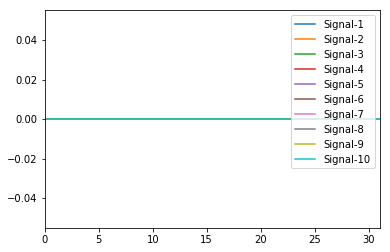

Topics Terms for Mirna023


,Topic Number,Topic Terms
0,1,"facetime, crazy, heard, britain, promised, han..."
1,2,"insane, jason, money, tuesday, blockheads, jen..."
2,3,"videos, people, win, pic, yeah, issues, crashi..."
3,4,"adidas, sheraton, site, sign, decided, total, ..."
4,5,"cute, afterall, gs, bocelli, jeans, drive, col..."
5,6,"enjoy, jump, canceled, num, click, min, camera..."
6,7,"btw, friday, thursday, feel, hun, donnie, inso..."
7,8,"sad, nights, jackson, literally, shout, tears,..."
8,9,"fellow, alcohol, seas, west, time, blockhead, ..."
9,10,"week, estrella, good, twitterland, business, c..."


Seeded Terms Per Topic for Mirna023


,Topic Number,Seed Terms:Count
0,signal_9,kill:14
1,signal_3,insomniac:2
2,signal_2,depressed:14


Topics Probabilties Over Time for luckygnahhh


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,18/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
1,02/05/2009 - 02/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
2,02/05/2009 - 03/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0333333,0.0
3,02/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0219780,0.0
4,02/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0439560,0.0
5,02/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0219780,0.0
6,02/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0439560,0.0
7,02/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0329670,0.0
8,02/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0219780,0.0
9,02/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0219780,0.0


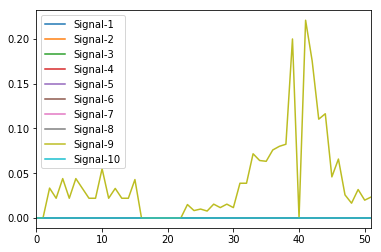

Topics Terms for luckygnahhh


,Topic Number,Topic Terms
0,1,"befriend, honey, awful, lie, ilybb, guys, ohoh..."
1,2,"love, mommy, mind, totes, skype, hate, pills, ..."
2,3,"heart, lied, people, sex, decided, laugh, cold..."
3,4,"ugh, mom, thankfully, laptop, tests, jesus, nb..."
4,5,"broke, cried, fucking, house, sad, wrecks, yea..."
5,6,"bawling, colleges, apple, figure, sweet, scare..."
6,7,"twitter, fuck, yellow, pass, ready, keep_forge..."
7,8,"week, angry, damn, hope, bb"
8,9,"poor, wands, notice, omg, remember, watching, ..."
9,10,"blind, crazy, worse, syncing, messages, half, ..."


Seeded Terms Per Topic for luckygnahhh


,Topic Number,Seed Terms:Count
0,signal_9,"hell:35, die:7"
1,signal_8,angry:5
2,signal_1,boredom:14
3,signal_2,breaking:7
4,signal_7,keep_forgetting:7
5,signal_6,worst:14


Topics Probabilties Over Time for Wolfgang_


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,03/05/2009 - 16/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
1,10/05/2009 - 17/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
2,10/05/2009 - 18/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
3,10/05/2009 - 18/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
4,10/05/2009 - 18/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
5,10/05/2009 - 18/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
6,10/05/2009 - 22/05/2009,0.0,0.0175439,0.0,0.0,0.0,0.0,0.0,0.0,0.0526316,0.0
7,10/05/2009 - 22/05/2009,0.0,0.0175439,0.0,0.0,0.0,0.0,0.0,0.0,0.0526316,0.0
8,14/05/2009 - 22/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0
9,14/05/2009 - 22/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000,0.0


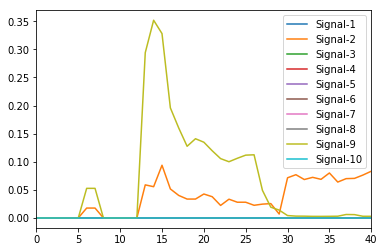

Topics Terms for Wolfgang_


,Topic Number,Topic Terms
0,1,"sound, fondle, missing, apps, tweetdeck, bum, ..."
1,2,"heartache, melancholy, pain, sitting, please, ..."
2,3,"lack, sharing, sleep, conditioner, cold, issue..."
3,4,"cute, brave, helpness, sigh, jeans, sob, happe..."
4,5,"morose, feel, sooo, lugguage, wth, appeared, w..."
5,6,"idea, books, aspect, chicken, style, sats, mis..."
6,7,"cyclist, lower, absolutely, engaged, traffic, ..."
7,8,"doesnt, dropped, sense, network, cuffs, depend..."
8,9,"injured, heart, dont, excitment, fire, mm, fel..."
9,10,"funny, work, hit, nursing, mb, helps, price, p..."


Seeded Terms Per Topic for Wolfgang_


,Topic Number,Seed Terms:Count
0,signal_9,"injured:14, hell:26"
1,signal_2,"heartache:9, miserable:36, melancholy:11, hear..."
2,signal_5,fat:9
3,signal_4,drained:10
4,signal_7,engaged:14
5,signal_6,worst:8


Topics Probabilties Over Time for stevegarufi


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,07/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,17/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


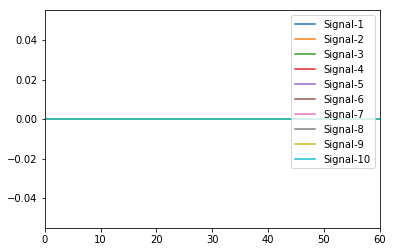

Topics Terms for stevegarufi


,Topic Number,Topic Terms
0,1,"someday, blew, selection, colorado, trails, fi..."
1,2,"mountain, vista, lots, house, buena, british, ..."
2,3,"category, michelle, shot, spoke, nearest, purs..."
3,4,"cute, moving, talking, defense, sleep, leah, w..."
4,5,", crazy, twitter, filly, images, goodness, rec..."
5,6,"fantastic, love, archesutah, errorless, honey,..."
6,7,"el, cadet, coach, photo, pig, cottonwood, pass..."
7,8,"things, laying, awesome, pic, years, lips, spe..."
8,9,"super, lived, sounds, couch, enjoyed, ground, ..."
9,10,"snowman, summer, major, move, snowfall, hair, ..."


Seeded Terms Per Topic for stevegarufi


,Topic Number,Seed Terms:Count
0,signal_5,fat:5
1,signal_4,lazy:14
2,signal_6,worst:14


Topics Probabilties Over Time for NKArmyTNgirl


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,18/04/2009 - 18/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,09/05/2009 - 09/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


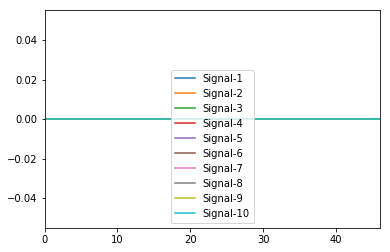

Topics Terms for NKArmyTNgirl


,Topic Number,Topic Terms
0,1,"people, pass, rough, worried, log, nighty, sup..."
1,2,"fish, names, flight, tan, praying, hmmm, funny..."
2,3,"peek, tweedeck, sad, missed, working, stl, ide..."
3,4,"stare, ps, good, played, uploading, tired, nan..."
4,5,"hom, pounds, mute, bus, ride, butt, virginia, ..."
5,6,"daughter, give_up, length, mykenzi, knee, asso..."
6,7,", summer, sucks, scared, yeah, numbers, allowe..."
7,8,"concert, napped, private, strap, email, though..."
8,9,"heart, ugh, singing, awesome, donnie, dead, po..."
9,10,"enjoy, walking, midnight, bluetooth, hair, cam..."


Seeded Terms Per Topic for NKArmyTNgirl


,Topic Number,Seed Terms:Count
0,signal_9,dead:14
1,signal_5,pounds:14
2,signal_4,tired:14
3,signal_6,give_up:21


Topics Probabilties Over Time for primatage


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,20/04/2009 - 03/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0000000,0.0,0.0,0.0,0.0
1,21/04/2009 - 04/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0000000,0.0,0.0,0.0,0.0
2,03/05/2009 - 04/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0000000,0.0,0.0,0.0,0.0
3,03/05/2009 - 04/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0000000,0.0,0.0,0.0,0.0
4,03/05/2009 - 04/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0000000,0.0,0.0,0.0,0.0
5,03/05/2009 - 04/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0000000,0.0,0.0,0.0,0.0
6,03/05/2009 - 04/05/2009,0.0,0.0000000,0.0,0.0,0.0,0.0000000,0.0,0.0,0.0,0.0
7,03/05/2009 - 10/05/2009,0.0,0.0619469,0.0,0.0,0.0,0.1681416,0.0,0.0,0.0,0.0
8,03/05/2009 - 11/05/2009,0.0,0.0336134,0.0,0.0,0.0,0.1596639,0.0,0.0,0.0,0.0
9,03/05/2009 - 11/05/2009,0.0,0.0420168,0.0,0.0,0.0,0.1260504,0.0,0.0,0.0,0.0


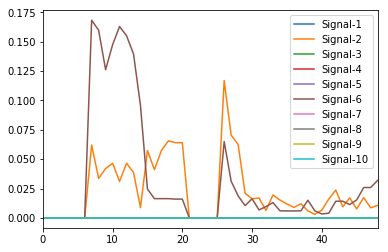

Topics Terms for primatage


,Topic Number,Topic Terms
0,1,"insane, reeks, forget, crowd, photo, sleep, da..."
1,2,"coffee, love, hehe, years, frustrated, sweet, ..."
2,3,"screw, eye, primatech, usps, coding, game, wor..."
3,4,"load, ridiculawesome, newest, agreed, play, mi..."
4,5,"hashtags, sad, denise, honest, feeding, nan, h..."
5,6,"limitations, wide, guess, awake, pot, flow, ye..."
6,7,"beautiful, cry, johnny, installed, watched, at..."
7,8,"consulting, feedback, deck, flung, freaked, bu..."
8,9,"meant, kind, things, haha, hear, grateful, hell"
9,10,"crap, payroll, send, keds, lol, night, follow,..."


Seeded Terms Per Topic for primatage


,Topic Number,Seed Terms:Count
0,signal_9,hell:34
1,signal_2,"disappointed:14, frustrated:14"
2,signal_6,"retard:14, worst:6, unnecessary:14"


Topics Probabilties Over Time for lopezwilfred


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,18/04/2009 - 01/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01/05/2009 - 02/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01/05/2009 - 02/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,01/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,01/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,01/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,01/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,01/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


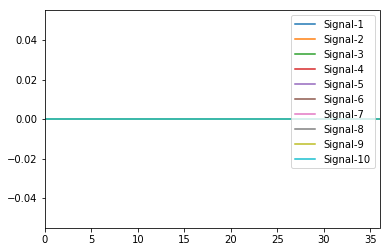

Topics Terms for lopezwilfred


,Topic Number,Topic Terms
0,1,"noticed, life, relaxin, effective, tired, tear..."
1,2,"twitterverse, love, pavarotti, taste, sweet, d..."
2,3,nan
3,4,"domain, lost, crowded, work, num, hatton, bet,..."
4,5,yeah
5,6,"twitter, sleepy, dog, fake, multiple, fb, fail..."
6,7,"breakfast, classes, confused, inviting, stuff"
7,8,"remains, starts, great, lag, upload"
8,9,"wow, nah"
9,10,"purchase, task, exchange, win, share, finished..."


Seeded Terms Per Topic for lopezwilfred


,Topic Number,Seed Terms:Count
0,signal_7,confused:5


Topics Probabilties Over Time for jennypoynter


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,14/05/2009 - 22/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0076336,0.0,0.0
1,17/05/2009 - 22/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0080000,0.0,0.0
2,17/05/2009 - 29/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0055556,0.0,0.0
3,17/05/2009 - 30/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0411392,0.0,0.0
4,18/05/2009 - 31/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0787671,0.0,0.0
5,22/05/2009 - 01/06/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0830189,0.0,0.0
6,22/05/2009 - 02/06/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0803859,0.0,0.0
7,22/05/2009 - 03/06/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0882353,0.0,0.0
8,22/05/2009 - 04/06/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0867052,0.0,0.0
9,29/05/2009 - 05/06/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0888252,0.0,0.0


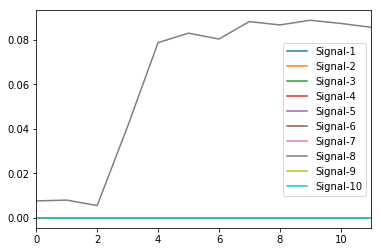

Topics Terms for jennypoynter


,Topic Number,Topic Terms
0,1,"amber, swim, walking, historyyy, missed, study..."
1,2,"earl, simon, gmtv, willis, premiere, bebo, hur..."
2,3,"ive, crowd, feel, jennifer, hair, outtt, aw, a..."
3,4,"fair, tuesday, move, bloody, fake, fail, woody..."
4,5,"ohh, frankie, people, yeaaah, toys, vote, slag..."
5,6,"dont, tonight, shame, doesnt, sense, probs, ye..."
6,7,"play, aha, wheezing, drunk, coulda, xxx, mwaha..."
7,8,"summer, czech, years, hug, video, chem, annoyi..."
8,9,"stalking, threethreethree, cope, dance, big, m..."
9,10,"spesh, funny, videos, time, scared, movie, bis..."


Seeded Terms Per Topic for jennypoynter


,Topic Number,Seed Terms:Count
0,signal_9,hurt:5
1,signal_8,"nervous:8, annoying:18"
2,signal_1,meh:7
3,signal_6,shame:9


Topics Probabilties Over Time for Leanne0710


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,30/05/2009 - 07/06/2009,0.0,0.0680529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01/06/2009 - 07/06/2009,0.0,0.0431655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01/06/2009 - 07/06/2009,0.0,0.0503597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,02/06/2009 - 15/06/2009,0.0,0.0338983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,03/06/2009 - 15/06/2009,0.0,0.0066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,04/06/2009 - 15/06/2009,0.0,0.0067568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,05/06/2009 - 15/06/2009,0.0,0.0068966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,06/06/2009 - 19/06/2009,0.0,0.0072993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,07/06/2009 - 20/06/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,15/06/2009 - 20/06/2009,0.0,0.0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


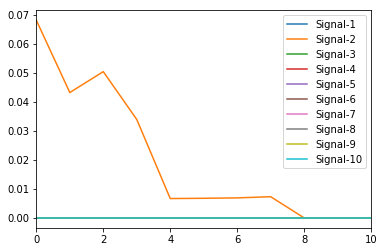

Topics Terms for Leanne0710


,Topic Number,Topic Terms
0,1,"funny, dreadin, earlier, boyles, weer, davina,..."
1,2,"maxine, showin, youtube, celebs, manage, walk,..."
2,3,"cry, love, money, twitter, sad, comin, thinkin..."
3,4,"feel, goodnighttt, haah, sed, dear, hah, rapid..."
4,5,"ladies, dont, tired, shel, al, sex, girl, okkk..."
5,6,", comment, people, dance, ano, saturday, ment,..."
6,7,"ive, replying, summer, ages, sunbathin, nopeee..."
7,8,"week, boy, annoying, fit, dictionary, chargin,..."
8,9,"yeh, jelous, trishs, hha, annoys, twitters, fi..."
9,10,"tickets, town, great, becky, hotubs, song, get..."


Seeded Terms Per Topic for Leanne0710


,Topic Number,Seed Terms:Count
0,signal_1,boring:3
1,signal_8,annoying:4
2,signal_3,all_nighter:1
3,signal_2,"dreading:1, frustrated:1"
4,signal_9,die:16


Topics Probabilties Over Time for shellrawlins


,Time Period,Signal-1,Signal-2,Signal-3,Signal-4,Signal-5,Signal-6,Signal-7,Signal-8,Signal-9,Signal-10
0,19/04/2009 - 19/04/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,03/05/2009 - 03/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,03/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,03/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,03/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,03/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,03/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,03/05/2009 - 04/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,03/05/2009 - 10/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,03/05/2009 - 11/05/2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


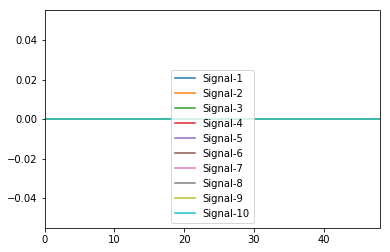

Topics Terms for shellrawlins


,Topic Number,Topic Terms
0,1,"summer, bacon, deep, years, feet, planning, ta..."
1,2,"saturday, rotas, brave, julie, rachel, expect,..."
2,3,"week, raining, wallingford, oi, toast, season,..."
3,4,"arse, pain, realise, sit, pay, hun, tired, veg..."
4,5,"matter, lovely, yay, worth, wine"
5,6,"evening, unfollow, watch, london, mmm, suppose..."
6,7,"work, confused, morning, makeover, easy, hope,..."
7,8,"biased, fosters, computer, watching, taste, ja..."
8,9,"office, cinema, share, yeah, dead, tonight, se..."
9,10,"enjoy, spotted, sees, deal, sweet, topic, resu..."


Seeded Terms Per Topic for shellrawlins


,Topic Number,Seed Terms:Count
0,signal_1,bored:14
1,signal_9,dead:14
2,signal_4,tired:5
3,signal_7,confused:14


In [22]:
user_depression_outputs = {}

for user in user_sample:
    user_depression_outputs[user] = detect_depression(user_LDA_outputs[user],user)